In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)
from mmcv import Config
import mmcv
from mmdet.apis import set_random_seed
# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
from mmcv.runner import load_checkpoint
from mmdet.apis import multi_gpu_test, single_gpu_test
print(get_compiling_cuda_version())
print(get_compiler_version())
from mmdet.datasets import build_dataset, build_dataloader
from mmdet.models import build_detector
from mmdet.apis import train_detector
import copy
import os.path as osp
from mmcv.parallel import MMDataParallel
import mmcv
import numpy as np
import json
import os
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

1.7.0 True
2.16.0
12.2
GCC 11.4


## Visualize 1-case

In [2]:
cfg = Config.fromfile('configs/spine/mask_rcnn_r50_fpn_4x_coco.py')
# Set up working dir to save files and logs.
cfg.work_dir = 'work_dirs/mask_rcnn_r50_fpn_2x_coco_cp4'
checkpoint = cfg.work_dir +'/latest.pth'
cfg.model.train_cfg = None
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint, map_location='cpu')
model.CLASSES = checkpoint['meta']['CLASSES']
model = MMDataParallel(model, device_ids=[0])

/home/hg119@dhe.duke.edu/miniconda3/envs/spine-env/lib/python3.8/site-packages/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


Use load_from_local loader


/home/hg119@dhe.duke.edu/miniconda3/envs/spine-env/lib/python3.8/site-packages/mmdet/datasets/utils.py:65: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/home/hg119@dhe.duke.edu/miniconda3/envs/spine-env/lib/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/hg119@dhe.duke.edu/miniconda3/envs/spine-env/lib/python3.8/site-packages/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


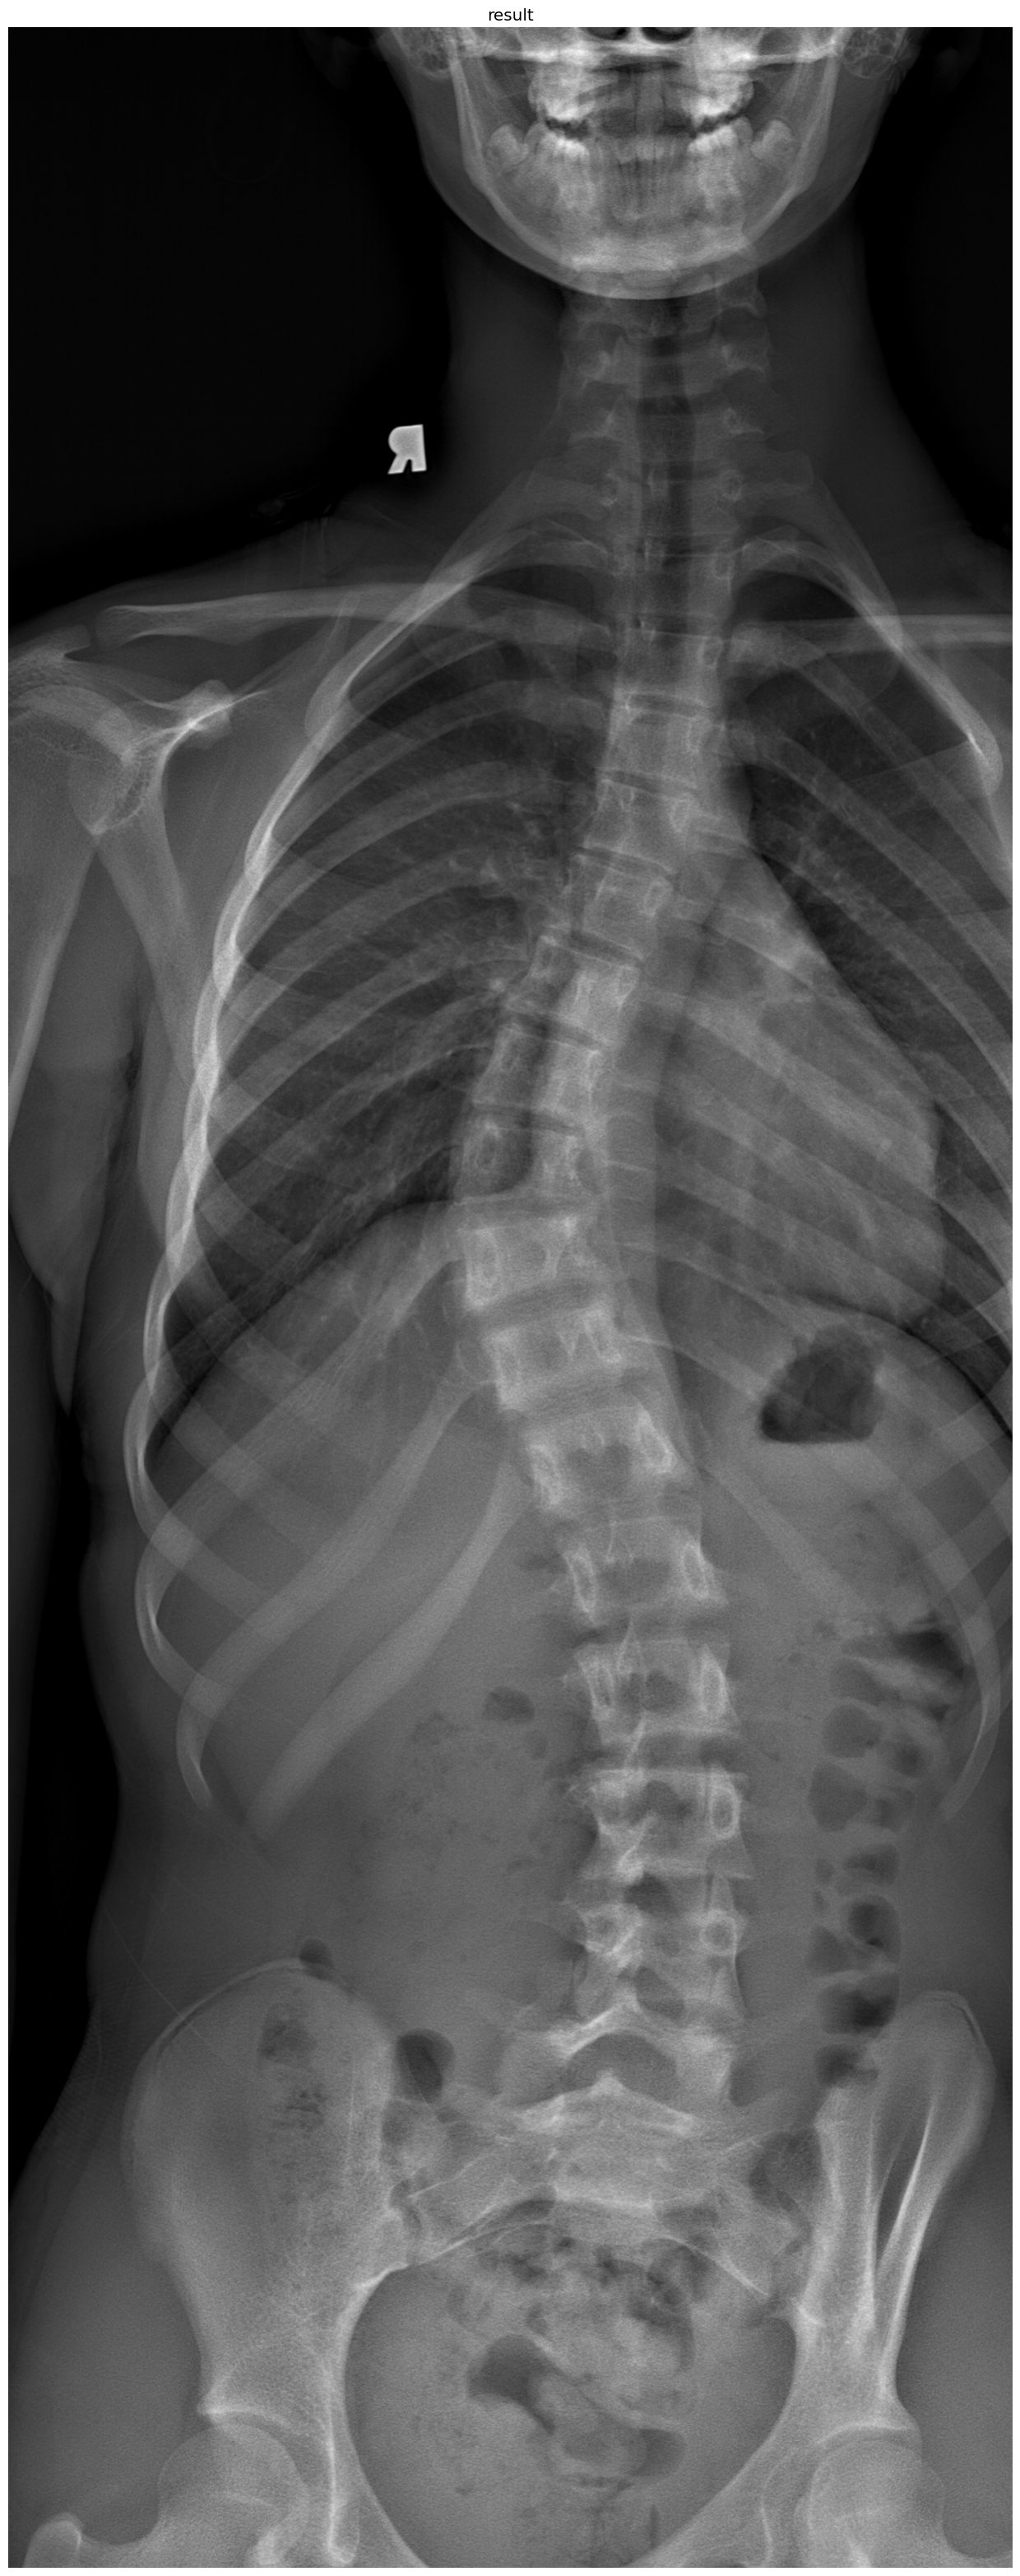

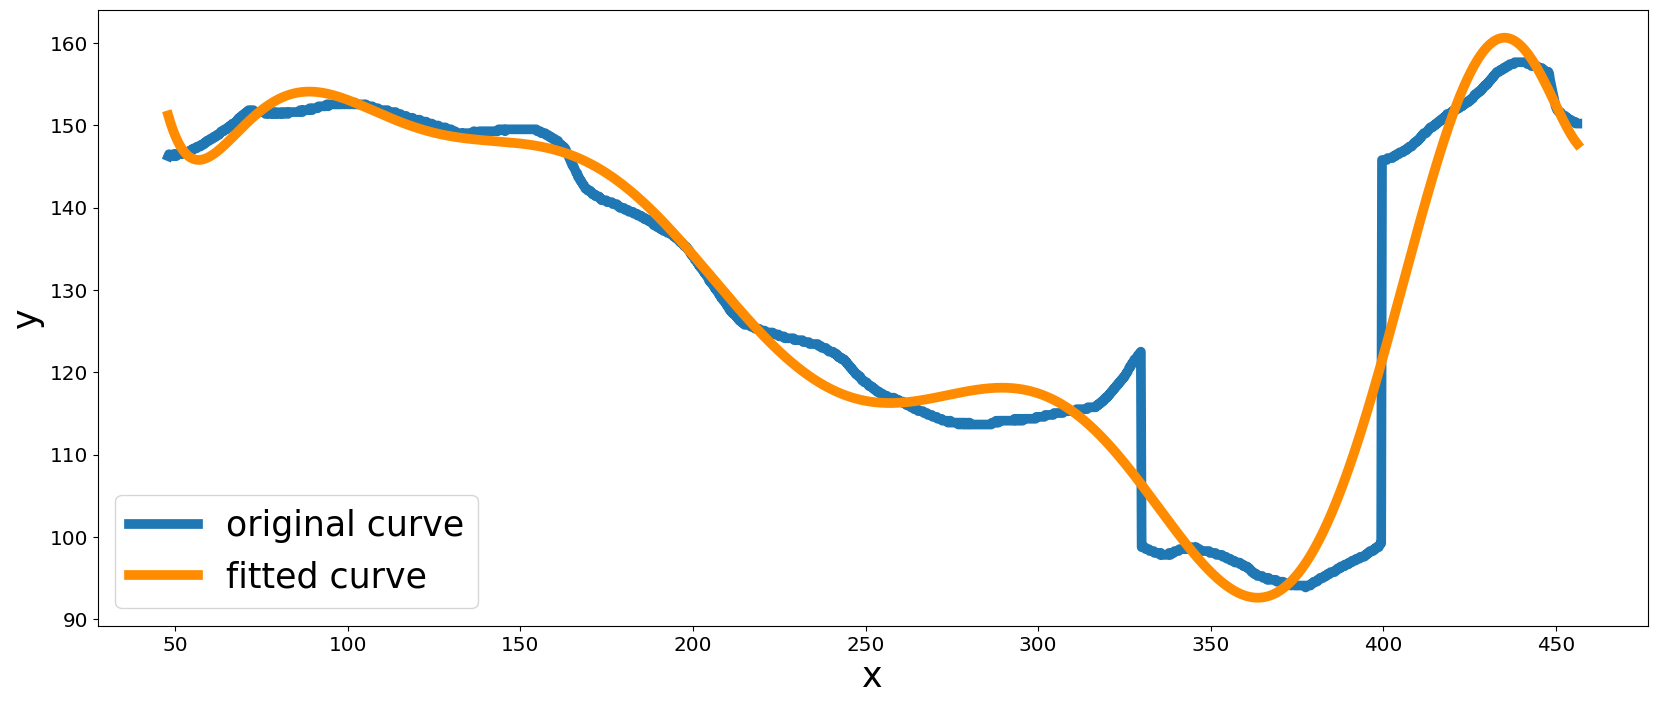

break point [47, 88, 257, 363, 456]
peaks [ 21  60 159 227 288 359 403]


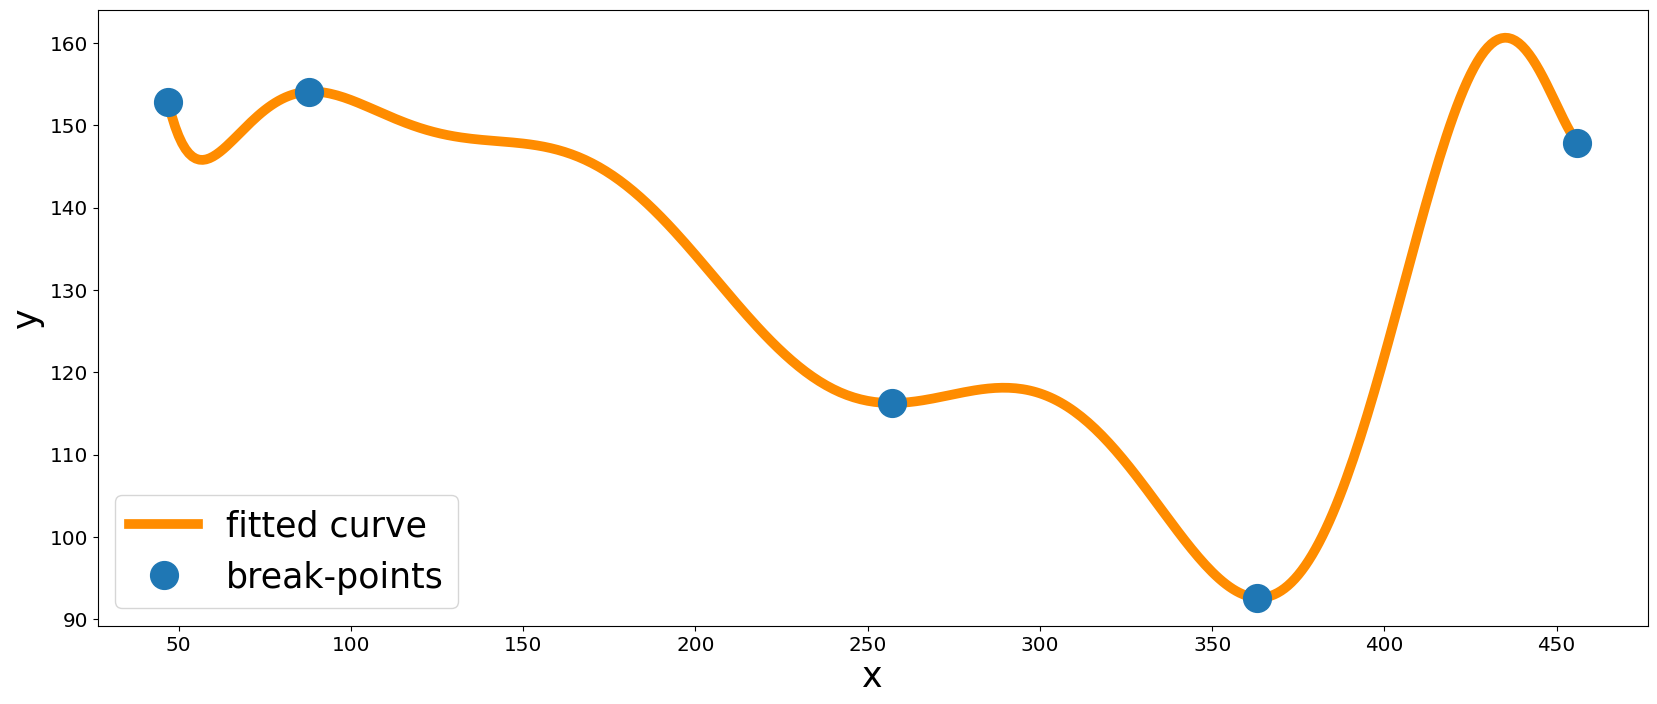

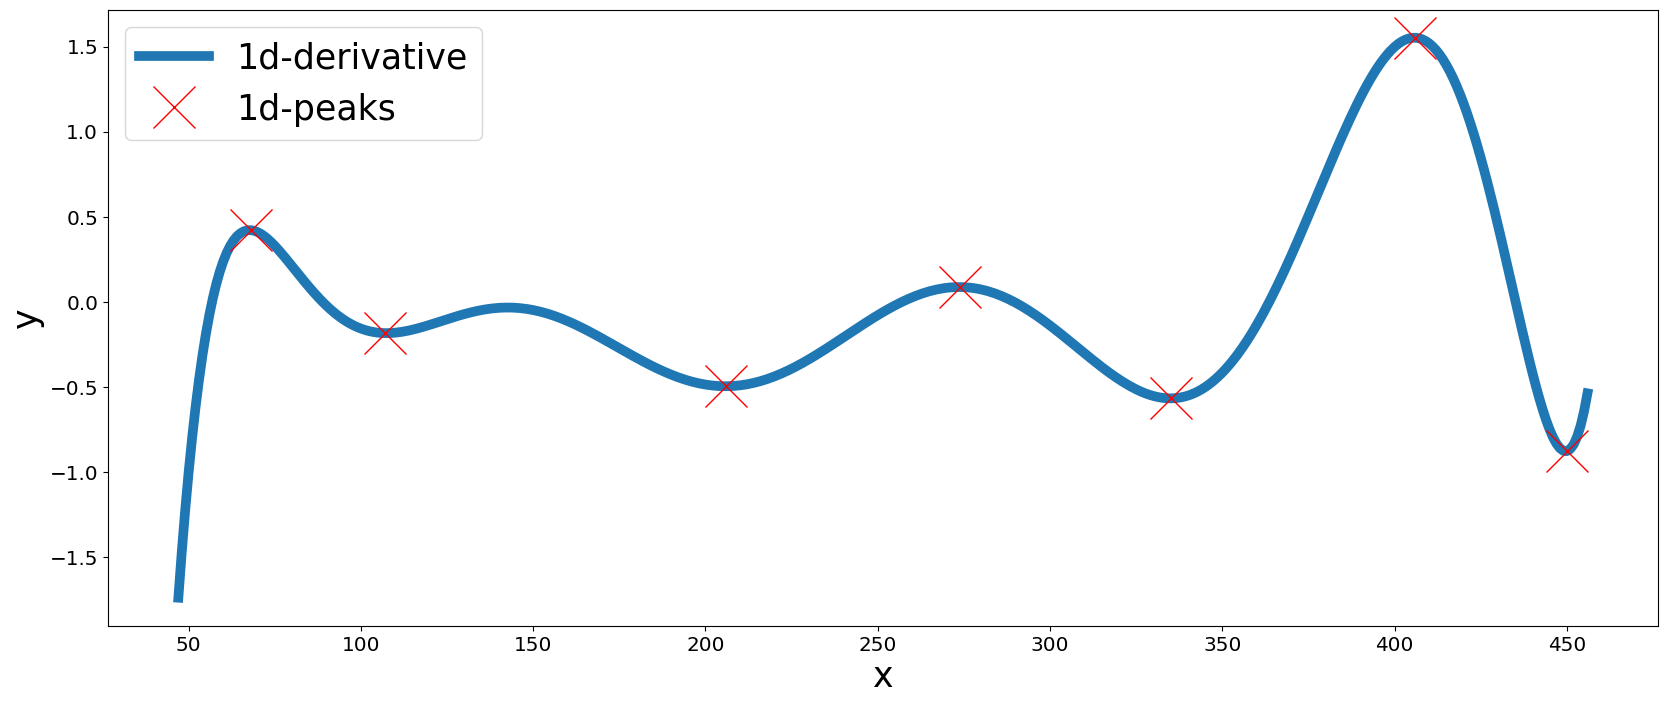

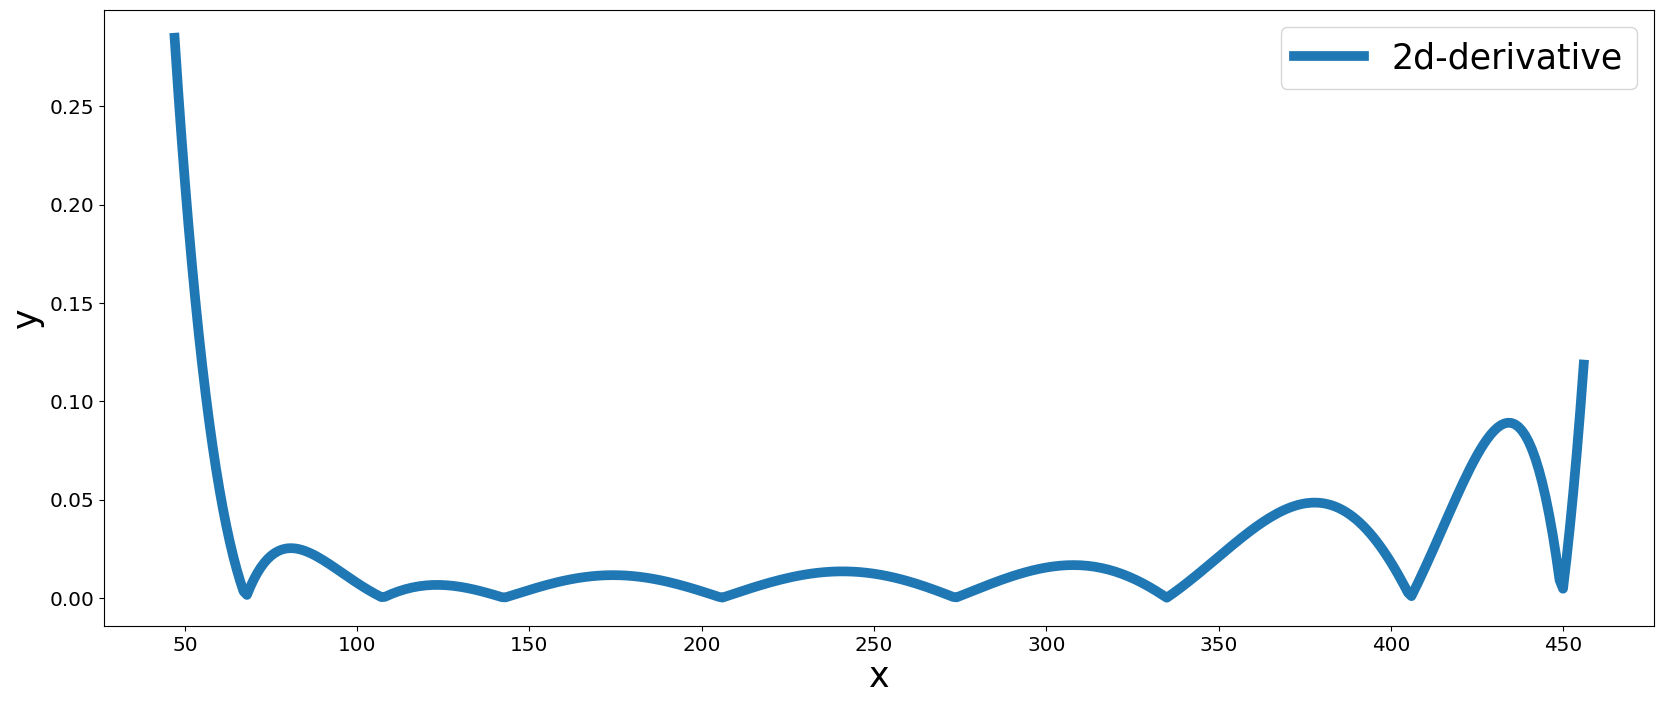

[448, 624, 1350, 1805, 2204]
off_x 0
peak, mid, tol 68 67.30552941824341 6.148325178690747
0.38942286645497315
off_x 0
peak, mid, tol 206 172.33941788754368 25.361841362099327
-0.43709996679515994
off_x 0
peak, mid, tol 335 309.86161553969845 15.894817933547108
-0.5201495876547357
off_x 0
peak, mid, tol 406 409.3061174829162 13.938532649418223
1.448315007383097


[44.88721319016789, 3.8710407489002123, 82.85774669718032]

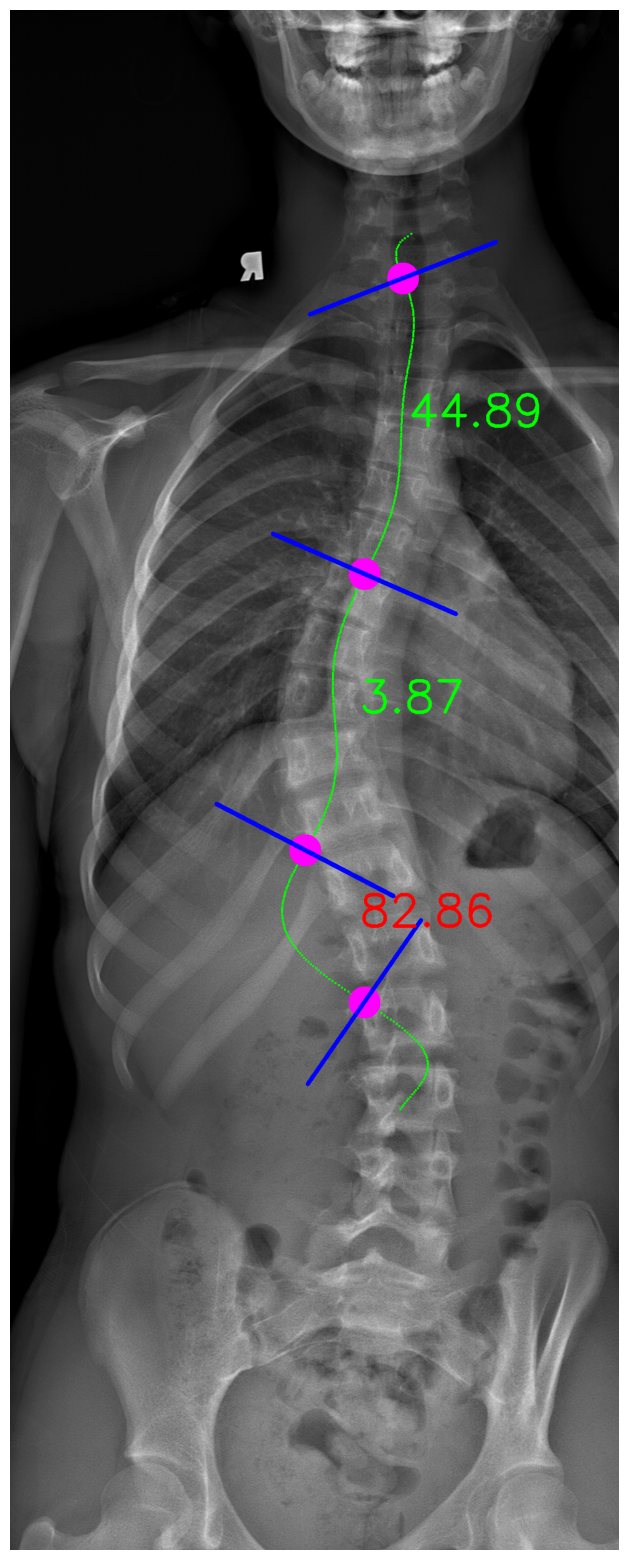

In [3]:
from utils_f import *
img = mmcv.imread('example_case/110.png')
model.cfg = cfg
seg_result = inference_detector(model, img)
show_result_pyplot(model, img, seg_result,score_thr=0.8)
image = np.array(img)
mask = np.array(seg_result[1][0][0])
box = np.array(seg_result[0][0][0])
result = mask_angle(image,mask,box)
skeleton, points_x, points_y = result.mask2skeleton()

# fine break point
break_points, new_skeleton, x_fit, f_x, f_x_1d, x_offset, y_offset,break_i  = result.find_break_point(points_x,points_y,if_draw=True)
print(break_points)

# separate the curve by break points
skes,start_x,end_x = result.sp_skeleton(new_skeleton,break_points,tol_ratio=0.3)


# steepest point method
image,angles,xcs,ycs = result.steepest_point_method(image, new_skeleton, break_points, x_fit, f_x, f_x_1d, x_offset, y_offset,break_i,tol_ratio=0.15,off_l=0)  # tol_ratio=0.15 off_l = 35
max_angle_id = angles.index(max(angles)) # find max angle index


for i in range(len(angles)):
    if i ==max_angle_id:
        result.draw_max_degree(image,xcs[i],ycs[i],xcs[i+1],ycs[i+1],angles[i])
    else:
        result.draw_max_degree(image,xcs[i],ycs[i],xcs[i+1],ycs[i+1],angles[i],c=(0,255,0))
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
angles